In [1]:
import pandas as pd
import numpy as np

In [2]:
import re
import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
train=pd.read_csv('train_data.csv')
train.head()

,text,label,data_source
0,AHHH I HOPE YOUR OK ! ! !,negative,sentiment-140
1,"cool , i have no tweet apps for my razr 2",negative,sentiment-140
2,i know just family drama . its lame.hey next t...,negative,sentiment-140
3,School email won't open and I have geography s...,negative,sentiment-140
4,upper airways problem,negative,sentiment-140


In [5]:
train.groupby('label')['label'].count() 

label
negative    13652
neutral     11767
positive    14634
Name: label, dtype: int64

In [6]:
test=pd.read_csv('test_data.csv')
test.head()

,text,label,data_source
0,I loooooooovvvvvveee my Kindle2. Not that the ...,positive,sentiment-140
1,Reading my kindle2. . . Love it . . . Lee chil...,positive,sentiment-140
2,"Ok , first assesment of the #kindle2 . . . it ...",positive,sentiment-140
3,You'll love your Kindle2. I've had mine for a ...,positive,sentiment-140
4,Fair enough . But i have the Kindle2 and I thi...,positive,sentiment-140


### 1. Text Processing

- All lower-case
- Remove url
- Expand short forms
- Remove punctuations (except "!!!")
- Tokenization
- Remove numbers 
- Remove stop words


In [9]:
def clean_text(df):
    all_posts = list()
    lines = df["text"].values.tolist()
    for text in lines:
        #All lower-case
        text = text.lower() 
        
        #Remove url
        pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+') 
        text = pattern.sub('', text)
        
        #Expand short forms
        text = re.sub(r"i'm", "i am", text)
        text = re.sub(r"he's", "he is", text)
        text = re.sub(r"she's", "she is", text)
        text = re.sub(r"that's", "that is", text)        
        text = re.sub(r"what's", "what is", text)
        text = re.sub(r"where's", "where is", text) 
        text = re.sub(r"\'ll", " will", text)  
        text = re.sub(r"\'ve", " have", text)  
        text = re.sub(r"\'re", " are", text)
        text = re.sub(r"\'d", " would", text)
        text = re.sub(r"\'ve", " have", text)
        text = re.sub(r"won't", "will not", text)
        text = re.sub(r"wont", "will not", text)
        text = re.sub(r"don't", "do not", text)
        text = re.sub(r"dont", "do not", text)
        text = re.sub(r"did't", "did not", text)
        text = re.sub(r"didnt", "did not", text)
        text = re.sub(r"can't", "can not", text)
        text = re.sub(r"cant", "can not", text)
        text = re.sub(r"it's", "it is", text)
        text = re.sub(r"couldn't", "could not", text)
        text = re.sub(r"have't", "have not", text)
        
        #substitute emoji
        text = re.sub(r":\)", "happy", text)
        text = re.sub(r":\(", "sad", text)
        
        #Remove punctuations "!" not included
        text = re.sub(r"[,.\"@#$%^&*(){}?/;`~:<>+=-]", "", text)
        
        #Tokenize for furthur processing
        tokens = word_tokenize(text)
        
        #Remove punctuations
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        
        #Remove numbers
        words = [word for word in stripped if word.isalpha()]
        
        #Remove stop words

        stop_words = set(stopwords.words("english"))
        stop_words.discard("not")
        stop_words.discard("no")
        stop_words.discard("never")
        stop_words.discard("why")
        words = [w for w in words if not w in stop_words]
        
        #token to sentence
        words = ' '.join(words)
        all_posts.append(words)
    return all_posts


In [10]:
all_posts_train = clean_text(train)
all_posts_train[0:5]

['ahhh hope ok',
 'cool no tweet apps razr',
 'know family drama lamehey next time u hang kim n u guys like sleepover whatever ill call u',
 'school email not open geography stuff revise stupid school',
 'upper airways problem']

In [11]:
train['cleaned_text']=all_posts_train

In [12]:
train=train[['text','cleaned_text','label']]
train.head()

,text,cleaned_text,label
0,AHHH I HOPE YOUR OK ! ! !,ahhh hope ok,negative
1,"cool , i have no tweet apps for my razr 2",cool no tweet apps razr,negative
2,i know just family drama . its lame.hey next t...,know family drama lamehey next time u hang kim...,negative
3,School email won't open and I have geography s...,school email not open geography stuff revise s...,negative
4,upper airways problem,upper airways problem,negative


In [13]:
all_posts_test = clean_text(test)
test['cleaned_text']=all_posts_test
test=test[['text','cleaned_text','label']]
test.head()

,text,cleaned_text,label
0,I loooooooovvvvvveee my Kindle2. Not that the ...,loooooooovvvvvveee not dx cool fantastic right,positive
1,Reading my kindle2. . . Love it . . . Lee chil...,reading love lee childs good read,positive
2,"Ok , first assesment of the #kindle2 . . . it ...",ok first assesment fucking rocks,positive
3,You'll love your Kindle2. I've had mine for a ...,love mine months never looked back new big one...,positive
4,Fair enough . But i have the Kindle2 and I thi...,fair enough think perfect happy,positive


### 2. Model training & evaluation

#### 2.1 prepare train test data

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer #feature engineer
from sklearn.decomposition import TruncatedSVD #dimension reduction
from sklearn.preprocessing import LabelEncoder #label encoding

In [15]:
#label encoding
LE = LabelEncoder()
train['label_num'] = LE.fit_transform(train['label'])
test['label_num'] = LE.fit_transform(test['label'])
#negative:0
#neutral:1
#positive:2

In [16]:
#feature engineer
tfidf_vectorizer = TfidfVectorizer(min_df = 5)

X_train= tfidf_vectorizer.fit_transform(train['cleaned_text']) #features
y_train= train['label_num'].values #target

print (X_train.shape)
print(y_train.shape)

(40053, 7015)
(40053,)


In [17]:
#dimension reduction
lsa = TruncatedSVD(n_components=100, 
                   n_iter=10, 
                   random_state=3)

X_train = lsa.fit_transform(X_train)
X_train.shape

(40053, 100)

In [18]:
#feature engineer
X_test= tfidf_vectorizer.transform(test['cleaned_text']) #features
y_test= test['label_num'].values #target

print (X_test.shape)
print(y_test.shape)

(6082, 7015)
(6082,)


In [19]:
#dimension reduction
X_test = lsa.transform(X_test)
X_test.shape

(6082, 100)

#### 2.2 experiment different models

In [20]:
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix

In [22]:
#create a dict of the models
model_dict = {'Dummy' : DummyClassifier(),
              'Decsision Tree': DecisionTreeClassifier(),
              'Random Forest': RandomForestClassifier(),
              'AdaBoost': AdaBoostClassifier(),
              'Gaussian Naive Bayes': GaussianNB(),
              'K Nearest Neighbor': KNeighborsClassifier()}


In [23]:
#fit model and calculate score
def model_score_df(model_dict):   
    model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []
    for k,v in model_dict.items():   
        model_name.append(k)
        v.fit(X_train, y_train)
        y_pred = v.predict(X_test)
        ac_score_list.append(accuracy_score(y_test, y_pred))
        p_score_list.append(precision_score(y_test, y_pred, average='macro'))
        r_score_list.append(recall_score(y_test, y_pred, average='macro'))
        f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
        model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
        model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
        model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
    return model_comparison_df

model_score_df(model_dict)

,model_name,accuracy_score,precision_score,recall_score,f1_score
2,Random Forest,0.609339,0.597,0.59635,0.590595
3,AdaBoost,0.566426,0.551304,0.552421,0.545379
5,K Nearest Neighbor,0.54949,0.552702,0.544515,0.540771
1,Decsision Tree,0.479448,0.470986,0.471049,0.470777
4,Gaussian Naive Bayes,0.480434,0.507912,0.476016,0.463437
0,Dummy,0.349227,0.345812,0.346062,0.345819


In [24]:
from sklearn.model_selection import GridSearchCV

In [25]:
#tune best model parameter
#random forest

param_grid = {
    'n_estimators': [10],
    'max_depth': [2, 4, 6, 8],
    'min_samples_leaf': [2, 4, 6, 8]
}

rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best Hyperparameters:", grid_search.best_params_)

Best Hyperparameters: {'max_depth': 8, 'min_samples_leaf': 8, 'n_estimators': 10}


In [ ]:
# best parameter model perform worse than default model, maybe overfit

In [27]:
rf = RandomForestClassifier()#use default model
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print('accuracy is:',accuracy_score(y_test, y_pred))
print('precision is:',precision_score(y_test, y_pred, average='macro'))
print('recall is:',recall_score(y_test, y_pred, average='macro'))
print('f1 is',f1_score(y_test, y_pred, average='macro'))

accuracy is: 0.6139427819796119
precision is: 0.6033318782663109
recall is: 0.6013243019722442
f1 is 0.5965204410007544


#### Random forest is the best model.

#### 2.3 result evaluation

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
conf_mat = confusion_matrix(y_test, y_pred,labels=[0, 1, 2])
class_names = ['negative', 'neutral', 'positive']

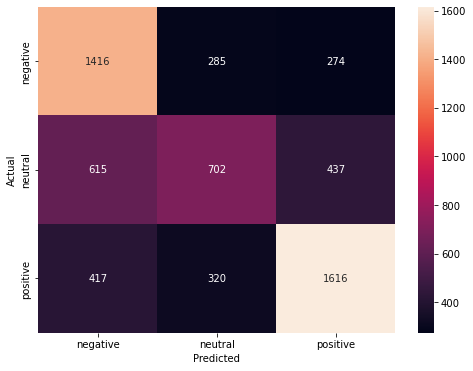

In [30]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [31]:
conf_mat

array([[1416,  285,  274],
       [ 615,  702,  437],
       [ 417,  320, 1616]], dtype=int64)

In [32]:
print('negative precision:',conf_mat[0,0]/sum(conf_mat[:,0]))
print('neutral precision:',conf_mat[1,1]/sum(conf_mat[:,1]))
print('positive precision:',conf_mat[2,2]/sum(conf_mat[:,2]))

negative precision: 0.5784313725490197
neutral precision: 0.5371078806426932
positive precision: 0.6944563816072196


In [33]:
print('negative recall:',conf_mat[0,0]/sum(conf_mat[0,:]))
print('neutral recall:',conf_mat[1,1]/sum(conf_mat[1,:]))
print('positive recall:',conf_mat[2,2]/sum(conf_mat[2,:]))

negative recall: 0.7169620253164557
neutral recall: 0.40022805017103763
positive recall: 0.6867828304292393


In [9]:
train.groupby('label')['label'].count() 

label
negative    13652
neutral     11767
positive    14634
Name: label, dtype: int64

#### Positive sentiments are best classified, neutral sentiments are classified worst.
- Data Imbalance: the number of positive and negative instances is much larger than the number of neutral instances. This can cause the model to favor the majority class and perform poorly on the minority class.

- Neutral sentiments often lack clear positive or negative cues, making them harder to classify. 

### 3. Error analysis

The below part is different from report. The text processing part is modified to account for some problems.

In [34]:
test['predicted_label']=y_pred

In [35]:
test.head(10)

,text,cleaned_text,label,label_num,predicted_label
0,I loooooooovvvvvveee my Kindle2. Not that the ...,loooooooovvvvvveee not dx cool fantastic right,positive,2,1
1,Reading my kindle2. . . Love it . . . Lee chil...,reading love lee childs good read,positive,2,2
2,"Ok , first assesment of the #kindle2 . . . it ...",ok first assesment fucking rocks,positive,2,1
3,You'll love your Kindle2. I've had mine for a ...,love mine months never looked back new big one...,positive,2,2
4,Fair enough . But i have the Kindle2 and I thi...,fair enough think perfect happy,positive,2,2
5,no . it is too big . I'm quite happy with the ...,no big quite happy,positive,2,2
6,Fuck this economy . I hate aig and their non l...,fuck economy hate aig non loan given asses,negative,0,0
7,Jquery is my new best friend .,jquery new best friend,positive,2,2
8,how can you not love Obama ? he makes jokes ab...,not love obama makes jokes,positive,2,2
9,Check this video out - - President Obama at th...,check video president obama white house corres...,neutral,1,1


In [36]:
error_data=test[test['label_num']!=test['predicted_label']]
error_data.shape

(2348, 5)

#### There are 6 types of errors. Below are some potential reasons.

- the TF-IDF model takes into account the frequency and importance of each word in a corpus, so if the overall context and usage of the words in the corpus do not indicate a negative sentiment, the model may not classify the sentence as negative. this explanation applies to all errors. data balance is important.
- misspell: can't to cant, so the negative "not" is not identified (dealt with in text processing part)
- should not remove some punctuations like "!", ':(', ':)' or should replace them as words (dealt with in text processing part)


- some positive words mixed: firmly believe, dear, cheering, glad
- wrong label: Lebron is a Beast , but I'm still cheering 4 the A..til the end. it looks positive to me? 165, 200 hard to tell if they are positive or sarcasm
- multiple emotions within one text
- punctuations without space is a problem. after removing punctuation, multiple words are joined

#### 3.1 negative classified as neutral 0->1

In [37]:
pd.set_option('display.max_colwidth', None)

In [38]:
error_data[(error_data['label_num']==0) & (error_data['predicted_label']==1)][['cleaned_text','text']].head(10)

,cleaned_text,text
33,us planning resume military tribunals guantanamo bay time trial aig execs chrysler debt holders,US planning to resume the military tribunals at Guantanamo Bay . . . only this time those on trial will be AIG execs and Chrysler debt holders
35,itchy miserable,I'm itchy and miserable !
36,no not itchy maybe later lol,"no . I'm not itchy for now . Maybe later , lol ."
43,glad not bay breakers today freaking degrees san francisco wtf,"glad i didnt do Bay to Breakers today , it's 1000 freaking degrees in San Francisco wtf"
47,obama administration must stop bonuses aig ponzi schemers,? Obama Administration Must Stop Bonuses to AIG Ponzi Schemers . . .
58,omg commercials alone espn going drive nuts,omg . The commercials alone on ESPN are going to drive me nuts .
71,told nike layoffs started today,: Was just told that Nike layoffs started today :-(
86,go ahead blow north korea map already,Can we just go ahead and blow North Korea off the map already ?
101,dick cheney dishonest speech torture terror obama fred kaplan slate,"Dick Cheney's dishonest speech about torture , terror , and Obama . - Fred Kaplan Slate ."
145,time warner devil worst possible time internet go,Time warner is the devil . Worst possible time for the Internet to go out .


#### 3.2 negative classified as positive 0->2

In [39]:
error_data[(error_data['label_num']==0) & (error_data['predicted_label']==2)][['cleaned_text','text']].head(10)

,cleaned_text,text
13,dear nike stop flywire shit waste science ugly love,"dear nike , stop with the flywire . that shit is a waste of science . and ugly . love , @vincentx24x"
15,talking guy last night telling die hard spurs fan also told hates lebron james,I was talking to this guy last night and he was telling me that he is a die hard Spurs fan . He also told me that he hates LeBron James .
53,annoying new trend internets people picking apart michael lewis malcolm gladwell nobody wants read,annoying new trend on the internets : people picking apart michael lewis and malcolm gladwell . nobody wants to read that .
63,twitter api slow client nt good,Because the twitter api is slow and most client's aren't good .
91,wish could catch every mosquito world n burn em slowlythey bitin shit outta mosquitos assholes insects,wish i could catch every mosquito in the world n burn em slowly.they been bitin the shit outta me 2day. mosquitos are the assholes of insects
99,cheney bush real culprits,Cheney and Bush are the real culprits -
135,night museum tonite instead sad oh well yr old better enjoy lol,Night at the Museum tonite instead of UP . :( oh well . that 4 yr old better enjoy it . LOL
139,oh yes gm dies worth boo hahaha,oh yes but if GM dies it will only be worth more boo hahaha
140,time warner cable time since memorial day bummer,Time Warner cable is down again 3rd time since Memorial Day bummer !
143,f ck time warner cable f cking suck balls hd tv damn hd channels hardly ever come bullshit,F * ck Time Warner Cable ! ! ! You f * cking suck balls ! ! ! I have a $700 HD tv & my damn HD channels hardly ever come in . Bullshit ! !


#### 3.3 neutral classified as negative 1->0

In [40]:
error_data[(error_data['label_num']==1) & (error_data['predicted_label']==0)][['cleaned_text','text']].head(10)

,cleaned_text,text
74,giving weka app engine interface using bird strike data tests logo given,"giving weka an app engine interface , using the bird strike data for the tests , the logo is a given ."
75,brand new canon eos dslr camera canon lens web technology thread brand new canon eos,"Brand New Canon EOS 50D 15MP DSLR Camera Canon 17-85mm IS Lens . . . : Web Technology Thread , Brand New Canon EOS 5. ."
128,going see night museum tall boy,Going to see night at the museum 2 with tall boy
156,myfoxdc barrie students back trip china silver spring high school class trip china en,myfoxdc Barrie Students Back from Trip to China : A Silver Spring high school's class trip to China has en . .
172,sony coupon code expires soon,Sony coupon code . . Expires soon . .
175,not realize gym safeway,Did not realize there is a gym above Safeway !
184,normal weight get normal eating blog,Your Normal Weight ( and How to Get There ) ? Normal Eating Blog
202,allstar basketball classic tuesday features top talent chattanooga notre dame high school play host,All-Star Basketball Classic Tuesday Features Top Talent : Chattanooga's Notre Dame High School will play host . .
211,man accosts roger federer french open,Man accosts Roger Federer during French Open
262,ok nothing thinking,ok . . do nothing . . just thinking about 40D


#### 3.4 neutral classified as positive 1->2


In [41]:
error_data[(error_data['label_num']==1) & (error_data['predicted_label']==2)][['cleaned_text','text']].head(10)

,cleaned_text,text
29,need suggestions good ir filter canon got pls dm,need suggestions for a good IR filter for my canon 40D . . . got some ? pls DM
30,checked google business blip shows second entry huh good ba,: I just checked my google for my business - blip shows up as the second entry ! Huh . Is that a good or ba . . . ? ~ 6emhv
52,going see star trek soon dad,Going to see star trek soon with my dad .
106,jquery ui book review,jQuery UI 1.6 Book Review -
119,hi anyone great source advice viral marketing,"Hi there , does anyone have a great source for advice on viral marketing ? . . ."
125,going see new night museum movie family oh boy three year old movies fuin,going to see the new night at the museum movie with my family oh boy a three year old in the movies fuin
127,saw new night museum movieit wasokaylol,Just saw the new Night at the Museum movie...it was...okay...lol 7 \ 10
133,saw night museum battle swithsonian today okay typical kids ben stiller movie,I saw Night at the Museum : Battle of the Swithsonian today . It was okay . Your typical [ kids ] Ben Stiller movie .
157,three china aerospace giants develop tianjin binhai new area b yuan invested,"Three China aerospace giants develop Tianjin Binhai New Area , 22.9 B yuan invested"
162,dentist tomorrow brush well morning like make hair nice get cut why,Dentist tomorrow . Have to brush well in the morning . Like I make my hair all nice before I get it cut . Why ?


#### 3.5 positive classified as negative 2->0


In [42]:
error_data[(error_data['label_num']==2) & (error_data['predicted_label']==0)][['cleaned_text','text']].head(10)

,cleaned_text,text
21,lebron beast nobody nba comes even close,Lebron is a beast . . . nobody in the NBA comes even close .
25,montreal long weekend r r much needed,In montreal for a long weekend of R & R . Much needed .
26,booz allen hamilton bad ass homegrown social collaboration platform way cool ttiv,Booz Allen Hamilton has a bad ass homegrown social collaboration platform . Way cool ! #ttiv
27,customer innovation award winner booz allen hamilton,[ #MLUC09 ] Customer Innovation Award Winner : Booz Allen Hamilton - -
113,ok lots buzz lucky free,Ok so lots of buzz from IO2009 but how lucky are they - a Free G2 ! !
161,wrist still hurts get looked hate dr dentist scary places sad time watch eagle eye want join txt,"My wrist still hurts . I have to get it looked at . I HATE the dr / dentist / scary places . :( Time to watch Eagle eye . If you want to join , txt !"
190,lovin nike already running spot bedroom,is lovin his Nike already and that's only from running on the spot in his bedroom
191,finally got around using jquery make bio collapse yay slide animations,I finally got around to using jquery to make my bio collapse . Yay for slide animations .
200,warren buffet became time richest man united states not working investing big idea lead fortune,"Warren Buffet became ( for a time ) the richest man in the United States , not by working but investing in 1 Big idea which lead to the fortune"
213,went stanford university today got tour made want go back college also decided kids go,We went to Stanford University today . Got a tour . Made me want to go back to college . It's also decided all of our kids will go there .


#### 3.6 positive classified as neutral 2->1

In [43]:
error_data[(error_data['label_num']==2) & (error_data['predicted_label']==1)][['cleaned_text','text']].head(10)

,cleaned_text,text
0,loooooooovvvvvveee not dx cool fantastic right,"I loooooooovvvvvveee my Kindle2. Not that the DX is cool , but the 2 is fantastic in its own right ."
2,ok first assesment fucking rocks,"Ok , first assesment of the #kindle2 . . . it fucking rocks ! ! !"
11,house correspondents dinner last night whoopi barbara sherri went obama got standing ovation,"House Correspondents dinner was last night whoopi , barbara & sherri went , Obama got a standing ovation"
12,watchin espnjus seen new nike commerical puppet lebronsh hilariouslmao,Watchin Espn..Jus seen this new Nike Commerical with a Puppet Lebron..sh * t was hilarious...LMAO ! ! !
18,lebron boss,lebron IS THE BOSS
40,going sleep bike ride,is going to sleep then on a bike ride :]
50,not regret going see star trek awesome,you will not regret going to see Star Trek . It was AWESOME !
61,hello twitter api,Hello Twitter API ;)
65,scrapbooking nic,is scrapbooking with Nic =D
73,way totally inspired freaky nike commercial,"By the way , I'm totally inspired by this freaky Nike commercial :"
